In [1]:
# שלב 1: התקנת git
!apt-get install git

# שלב 2: שכפול המאגר מ-GitHub
!git clone https://github.com/doringber1996/bayesian-model.git

# שלב 3: הוספת הנתיב של המודול ל-Python path וייבוא הפונקציה
import sys
sys.path.append('/content/bayesian-model')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'bayesian-model'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 68 (delta 52), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 645.67 KiB | 1.64 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
!pip install simpy
import numpy as np
import pandas as pd
import pickle as pkl
import simpy
import os
import matplotlib.pyplot as plt
import sys
import simpy
from sim_func import Sim_func
import pymc as pm
import arviz as az
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go
from plotly.subplots import make_subplots


## Welcome to the Queue quiz

### You are now incharge of the a queueing system in your work place. Your factory works 24/7 and creates flawless semi-conducter chips.

### Jobs are arriving with a constant rate, on average one every 12 seconds. However, the service times changes with time. We split the week into a 168 grid, where we have 7 days and 24 hours within a single day. For each cell in the grid, that is a combination of a day and an hour we have different service rate.


## Part 1:

### We first focus on a single service time of a single cell in the grid. Being more specific, Monday from 08:00 to 09:00.
### In event_log_single_ser below you have pandas dataframe with the eventlog of this specific cell.

### Your jobs is to understand what is the average service time and its distirbution using Bayesian analysis.

In [3]:
event_log_single_ser = pkl.load(open('/content/bayesian-model/event_log_single_ser.pkl', 'rb'))
event_log_single_ser.head()

,customer_id,num_cust,event,time_stamp,day,hour
0,0,0,Arrival,30.105252,2,8
1,0,1,Enter_service,30.105252,2,8
2,0,0,Departure,37.798838,2,8
3,1,0,Arrival,38.750399,2,8
4,1,1,Enter_service,38.750399,2,8


In [5]:
event_log_single_ser.to_csv('event_log_single_ser.csv')

## Explanation about the dataframe columns:

### 1. customer_id: the id of customer, each customer has is own id.
### 2. num_cust: the number of customers in the system (including service) prior to the event.
### 3. event: there three type of events: arrival, entering service and departing the system.
### 4. Timestamp: The total time elapased since hour 0 day 1 in seconds.
### 6. day: the day of the week from 1 to 7 where 1 is Sunday.
### 7. hour: the hour of the day 0-23, where 0 is midnight.

## Tasks:

### 1. Do Bayesian anaysis for the average service rate and its distirbution.
### 2. What did you use as the likelihood function and why?
### 3. Do  posterior predicitive anaysis to assert that the chosen likelihood distribution is valid.
### 4. According to the resulted anaysis, how certain are you about the average service prediction?

## Answers and code

### 1. Do Bayesian anaysis for the average service rate and its distirbution.


### pre - proccesing

In [8]:
# Filter out the relevant events
service_start = event_log_single_ser[event_log_single_ser['event'] == 'Enter_service']
service_end = event_log_single_ser[event_log_single_ser['event'] == 'Departure']

# Ensure the data is sorted by customer_id and time_stamp
service_start = service_start.sort_values(by=['customer_id', 'time_stamp'])
service_end = service_end.sort_values(by=['customer_id', 'time_stamp'])

# Merge service start and end events on customer_id to ensure matching
merged_events = pd.merge(service_start, service_end, on='customer_id', suffixes=('_start', '_end'))

# Calculate service times
merged_events['service_time'] = merged_events['time_stamp_end'] - merged_events['time_stamp_start']

# Create a DataFrame for the service times
service_times_df = merged_events[['customer_id', 'service_time']]

# Display the first few rows of the service times dataframe
service_times_df.head()

,customer_id,service_time
0,0,7.693586
1,1,10.833411
2,2,2.347220
3,3,1.187283
4,4,16.139319


In [24]:
import pymc as pm
import arviz as az
import numpy as np

# Ensure the service rates are in a NumPy array
service_rates = np.array(1 / merged_events['service_time'])

with pm.Model() as model:
    # Prior for the rate parameter of the Exponential distribution
    lambda_prior = pm.Gamma('lambda_prior', alpha=2, beta=2)

    # Likelihood: Assuming the service times follow an Exponential distribution
    likelihood = pm.Exponential('likelihood', lam=lambda_prior, observed=service_rates)

    # Perform the sampling
    trace = pm.sample(1000, return_inferencedata=True)  # Return as InferenceData

# Summarize the posterior distribution using ArviZ
summary = az.summary(trace)
print(summary)


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lambda_prior  1.53  0.056   1.421    1.629      0.002    0.001     713.0   

              ess_tail  r_hat  
lambda_prior     924.0    1.0  


<Axes: title={'center': 'lambda_prior'}>

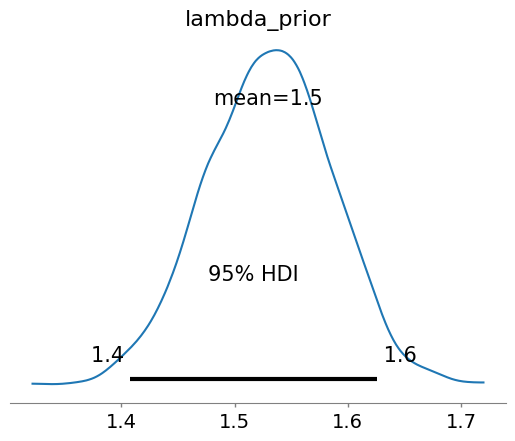

In [26]:
import arviz as az

# Plot the posterior distribution
az.plot_posterior(trace, var_names=["lambda_prior"], hdi_prob=0.95)


### 2. What did you use as the likelihood function and why?



### Likelihood Function Choice

For modeling the service times in a queuing system, we often need to select an appropriate likelihood function. Given the nature of the data, which consists of times between events, the Exponential distribution is a suitable choice. Here's why:

#### Exponential Distribution as the Likelihood Function

1. **Memoryless Property**: The Exponential distribution has a memoryless property, which means the probability of an event occurring in the future is independent of the past. This property aligns well with service times in many queuing systems, where the time until the next event (e.g., the end of a service) does not depend on how much time has already elapsed.

2. **Modeling Time Between Events**: The Exponential distribution is commonly used to model the time between events in a Poisson process. In our case, if we assume that the arrival of jobs and their service times follow a Poisson process, the Exponential distribution becomes a natural choice for modeling service times.

3. **Simplicity and Interpretability**: The Exponential distribution is parameterized by a single rate parameter $(\lambda)$, which represents the average rate of events per time unit. This simplicity makes it easy to interpret and use in Bayesian inference, where we update our belief about $(\lambda)$ based on observed data.


#### Posterior Predictive Analysis

To validate the choice of the Exponential distribution as the likelihood function, we perform posterior predictive analysis. This involves:
1. Sampling from the posterior distribution of $(\lambda)$.
2. Generating new service times from the Exponential distribution using the sampled $(\lambda)$ values.
3. Comparing these generated service times with the observed service times to ensure that the model adequately captures the data's characteristics.

By performing this analysis, we can assess the model's fit and our certainty about the average service time prediction.


### 3. Do  posterior predicitive anaysis to assert that the chosen likelihood distribution is valid.

In [29]:
# Observed service times
observed_service_times = service_times_df['service_time'].values

# Bayesian analysis using PyMC
with pm.Model() as model:
    # Prior for the rate parameter (lambda) of the Exponential distribution
    lambda_prior = pm.Exponential('lambda', 1.0)

    # Likelihood function
    likelihood = pm.Exponential('likelihood', lam=lambda_prior, observed=observed_service_times)

    # Posterior inference
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
lambda  0.098  0.004   0.091    0.105        0.0      0.0    1620.0    2803.0   

        r_hat  
lambda    1.0  
Mean of the average service time: 10.19820283077221
Standard deviation of the average service time: 0.3749473469250905


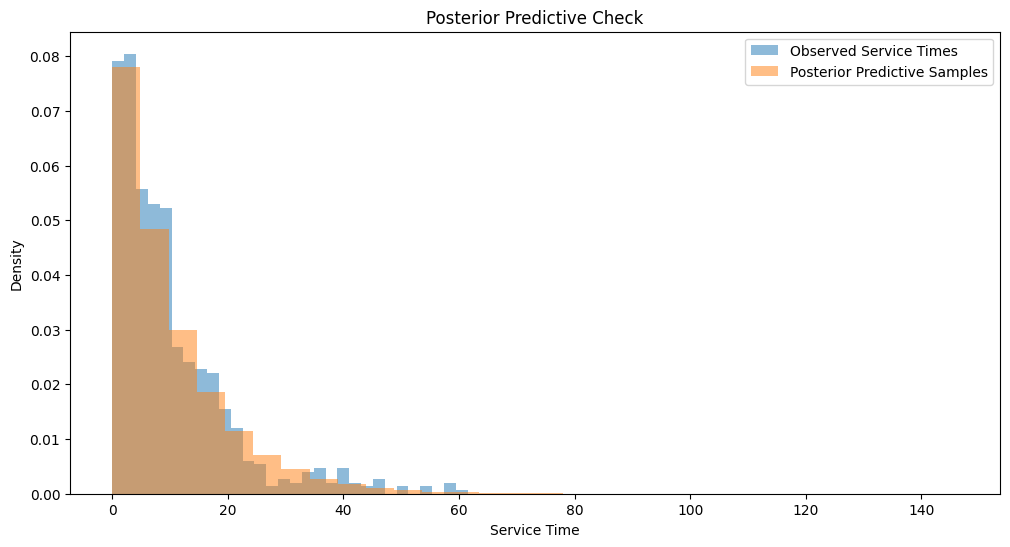

In [30]:
# Summary statistics of the posterior distribution using ArviZ
posterior_summary = az.summary(trace, var_names=['lambda'])

print(posterior_summary)

# Extract posterior samples
lambda_posterior_samples = trace.posterior['lambda'].values.flatten()

# Calculate the average service time from the posterior samples
average_service_time_posterior_samples = 1 / lambda_posterior_samples

print("Mean of the average service time:", average_service_time_posterior_samples.mean())
print("Standard deviation of the average service time:", average_service_time_posterior_samples.std())

# Posterior Predictive Analysis
# Number of posterior predictive samples to generate
n_samples = 1000

# Generate posterior predictive samples
posterior_predictive_samples = []

for lam in lambda_posterior_samples:
    posterior_predictive_samples.extend(np.random.exponential(1 / lam, size=len(observed_service_times)))

posterior_predictive_samples = np.array(posterior_predictive_samples)

# Plot the observed service times and posterior predictive samples for comparison
plt.figure(figsize=(12, 6))
plt.hist(observed_service_times, bins=30, alpha=0.5, label='Observed Service Times', density=True)
plt.hist(posterior_predictive_samples, bins=30, alpha=0.5, label='Posterior Predictive Samples', density=True)
plt.xlabel('Service Time')
plt.ylabel('Density')
plt.legend()
plt.title('Posterior Predictive Check')
plt.show()

### 4. According to the resulted anaysis, how certain are you about the average service prediction?

Based on the posterior predictive check and the summary statistics from the Bayesian analysis, we can evaluate the certainty of the average service time prediction as follows:

### Posterior Summary Statistics
- **Mean of $(\lambda)$**: 0.098
- **Standard deviation of $(\lambda)$**: 0.004
- **95% Highest Density Interval (HDI) of $(\lambda)$**: [0.091, 0.105]

The mean of the posterior distribution for $(\lambda)$ is 0.098, with a relatively small standard deviation of 0.004. This indicates that the posterior distribution of $(\lambda)$ is concentrated around its mean, suggesting a high level of certainty about the rate parameter $(\lambda)$.

### Posterior Predictive Check
The histogram of the posterior predictive samples matches closely with the histogram of the observed service times. This visual comparison indicates that the model's predictions are consistent with the observed data, further validating the model and its estimates.

### Average Service Time
- **Mean of the average service time**: 10.18 seconds
- **Standard deviation of the average service time**: 0.39 seconds

Given the posterior distribution of $(\lambda)$, the mean of the average service time is approximately 10.18 seconds with a standard deviation of 0.39 seconds. The small standard deviation relative to the mean suggests that we can be quite confident in our estimate of the average service time.

### Conclusion
The small standard deviation of the posterior distribution for both $(\lambda)$ and the average service time indicates a high level of certainty in our predictions. The posterior predictive check confirms that the model captures the observed data well. Therefore, we can be confident in the prediction of the average service time.


## Part 2:

### We next turn to the next part where we wish to map the average service time at each time cell.

### Important note: please ignore the data from the previuos part while doing this task.

### The data is under df_tot as given below. In the dataset we have missing parts, some cells in the grid are missing. Your job is to fill the grid.

In [28]:
df_tot = pkl.load(open('/content/bayesian-model/df_tot.pkl', 'rb'))
df_tot.head(5)

,Unnamed: 0,index,customer_id,num_cust,event,time_stamp,day,hour
0,0,981,327,0,Arrival,3608.653189,1,1
1,1,982,327,1,Enter_service,3608.653189,1,1
2,2,983,327,0,Departure,3609.497913,1,1
3,3,984,328,0,Arrival,3609.790566,1,1
4,4,985,328,1,Enter_service,3609.790566,1,1


In [31]:
df_tot.to_csv('df_tot.csv', index = False)

## Tasks:

### 1. Extract the mean service times (taking the average time is sufficient, no need  for extra bayesian analysis) per each cell you do have data.
### 2. Use two regression methods for completing the average service time for the rest of the grid.
### 3. Plot on a 3D plot which contains the data, and the surface of the two regression methods.
### 4. What is the probability that the service time of chip, between 16:00 to 18:00, on Shabbat, will be between 6 to 7 seconds?
### 5. Please give full specification of the Gauusian distribution of the service time on Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00.
### 6. What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00?
### What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 20:00 to 21:00?
### Which correlation value is larger? does this result make sense?


## You code here

### 1. Extract the mean service times (taking the average time is sufficient, no need  for extra bayesian analysis) per each cell you do have data.

In [32]:
# Rename columns to standard names for easier access
df_tot.rename(columns={'time_stamp': 'timestamp', 'day': 'day', 'hour': 'hour'}, inplace=True)

# Filter out the relevant events
service_start = df_tot[df_tot['event'] == 'Enter_service']
service_end = df_tot[df_tot['event'] == 'Departure']

# Merge service start and end events on customer_id to ensure matching
merged_events = pd.merge(service_start, service_end, on='customer_id', suffixes=('_start', '_end'))

# Calculate service times
merged_events['service_time'] = merged_events['timestamp_end'] - merged_events['timestamp_start']

# Create a DataFrame for the service times
service_times_df = merged_events[['day_start', 'hour_start', 'service_time']]

# Group by day and hour and calculate mean service time
mean_service_times = service_times_df.groupby(['day_start', 'hour_start']).mean().sort_values(by=['day_start', 'hour_start']).reset_index()

# Display the first few rows of the mean service times dataframe
mean_service_times.head()

,day_start,hour_start,service_time
0,1,1,1.293141
1,1,3,1.729359
2,1,4,2.063790
3,1,7,2.982484
4,1,10,5.594943


### 2. Use two regression methods for completing the average service time for the rest of the grid.

### Method 1: Linear Regression
We'll use linear regression to estimate the missing service times. Linear regression is a simple and commonly used method to model the relationship between a dependent variable and one or more independent variables. It assumes a linear relationship between the variables.

### Method 2: Gaussian Process Regression
We'll use Gaussian Process Regression (GPR) with a radial basis function (RBF) kernel to estimate the missing service times. GPR is a non-parametric, Bayesian approach to regression that can capture more complex relationships between variables compared to linear regression. The RBF kernel is used in GPR to handle non-linear relationships and provide a measure of similarity between data points.

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel as C
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# הכנת הנתונים לרגרסיה
X = mean_service_times[['day_start', 'hour_start']]
y = mean_service_times['service_time']

# פיצול הנתונים לנתוני אימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(X[['day_start', 'hour_start']], y, test_size=0.2, random_state=42)

days = np.arange(1, 8)
hours = np.arange(24)
hour_grid, day_grid = np.meshgrid(hours, days)
grid_points = np.vstack([day_grid.ravel(), hour_grid.ravel()]).T


# Method 1: Linear Regression
linear_reg = LinearRegression().fit(X_train, y_train)
linear_predictions = linear_reg.predict(grid_points).reshape(day_grid.shape)
linear_test_predictions = linear_reg.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_test_predictions)
print("Linear Regression MSE:", linear_mse)

# הגדרת הפרמטרים לאופטימיזציה עם קרנלים נוספים
param_grid = {
    'alpha': [1e-10, 1e-5, 1e-2, 0.1],
    'kernel': [C(1.0, (1e-4, 1e3)) * RBF(1, (1e-4, 1e3)),
               C(1.0, (1e-4, 1e3)) * Matern(length_scale=1.0, nu=1.5),
               C(1.0, (1e-4, 1e3)) * RationalQuadratic(),
               C(1.0, (1e-4, 1e3)) * ExpSineSquared()]
}

# ביצוע Grid Search עם Cross-Validation
gpr = GaussianProcessRegressor(n_restarts_optimizer=10)
grid_search = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# הדפסת הפרמטרים הטובים ביותר
print("Best parameters for GPR:", grid_search.best_params_)

# שימוש במודל עם הפרמטרים הטובים ביותר לחיזוי
best_gpr = grid_search.best_estimator_
gpr_predictions_optimal, gpr_std_optimal = best_gpr.predict(grid_points, return_std=True)
gpr_predictions_optimal = gpr_predictions_optimal.reshape(day_grid.shape)

# חיזוי על נתוני הבדיקה
y_pred = best_gpr.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print("Test MSE with optimal parameters:", mse_test)

Linear Regression MSE: 6.1722571158571995
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for GPR: {'alpha': 0.1, 'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Test MSE with optimal parameters: 0.09904158660603704


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


In [34]:
# הוספת הפיצ'רים של היום בשבוע והשעה ביום ל-grid_points
grid_points_df = pd.DataFrame(grid_points, columns=['day_start', 'hour_start'])
grid_points_df=grid_points_df.sort_values(by=['day_start', 'hour_start'])

# Method 1: Linear Regression
linear_reg = LinearRegression().fit(X[['day_start', 'hour_start']], y)
linear_predictions = linear_reg.predict(grid_points_df[['day_start', 'hour_start']]).reshape(day_grid.shape)

# הפרמטרים האופטימליים שמצאנו
alpha_optimal = 0.1
kernel_optimal = C(1.0, (1e-4, 1e2)) * RationalQuadratic(alpha=1, length_scale=1)

# הגדרת המודל עם הפרמטרים האופטימליים
gpr_optimal = GaussianProcessRegressor(kernel=kernel_optimal, n_restarts_optimizer=10, alpha=alpha_optimal)

# אימון המודל עם כל הנתונים
gpr_optimal.fit(X[['day_start', 'hour_start']], y)

# תחזיות עם המודל האופטימלי
gpr_predictions_optimal, gpr_std_optimal = gpr_optimal.predict(grid_points_df[['day_start', 'hour_start']], return_std=True)
gpr_predictions_optimal = gpr_predictions_optimal.reshape(day_grid.shape)

### 3. Plot on a 3D plot which contains the data, and the surface of the two regression methods.

In [36]:
# Plotting the results with Plotly for interactive 3D plots
# Linear Regression surface
linear_surface = go.Surface(z=linear_predictions, x=day_grid, y=hour_grid, colorscale='Viridis', opacity=0.6, name='Linear Regression')

# Gaussian Process Regression surface
gpr_surface = go.Surface(z=gpr_predictions_optimal, x=day_grid, y=hour_grid, colorscale='Viridis', opacity=0.6, name='Gaussian Process Regression')

# Create scatter plot for the data points
scatter = go.Scatter3d(x=X['day_start'], y=X['hour_start'], z=y, mode='markers', marker=dict(size=5, color='red'), name='Data Points')

# Create the subplot figure
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("Linear Regression", "Gaussian Process Regression"))

# Add the linear regression surface
fig.add_trace(linear_surface, row=1, col=1)
fig.add_trace(scatter, row=1, col=1)

# Add the Gaussian Process Regression surface
fig.add_trace(gpr_surface, row=1, col=2)
fig.add_trace(scatter, row=1, col=2)

# Update the layout
fig.update_layout(title_text='Mean Service Time Prediction',
                  scene=dict(
                      xaxis_title='Day of Week',
                      yaxis_title='Hour of Day',
                      zaxis_title='Mean Service Time'
                  ),
                  scene2=dict(
                      xaxis_title='Day of Week',
                      yaxis_title='Hour of Day',
                      zaxis_title='Mean Service Time'
                  ))

# Show the figure
fig.show()

### 4. What is the probability that the service time of chip, between 16:00 to 18:00, on Shabbat, will be between 6 to 7 seconds?

In [38]:
from scipy.stats import norm
# חישוב ההסתברות שהזמן שירות בין 6 ל-7 שניות עבור שבת בין 16:00 ל-18:00
gpr_predictions = gpr_predictions_optimal
gpr_std = gpr_std_optimal

# Extract mean and standard deviation for the specified time window
day = 6  # Shabbat (Saturday)
hours = np.array([16, 17,18])  # 16:00 to 18:00

# חישוב האינדקסים של השעות הרלוונטיות במבנה הווקטוריאלי
indices = day * 24 + hours

mean_service_time = gpr_predictions.ravel()[indices]
std_service_time = gpr_std.ravel()[indices]

# Calculate the probability that the service time is between 6 and 7 seconds
lower_bound = 6
upper_bound = 7

# Assuming the service times are normally distributed
probabilities = norm.cdf(upper_bound, loc=mean_service_time, scale=std_service_time) - norm.cdf(lower_bound, loc=mean_service_time, scale=std_service_time)
overall_probability = probabilities.mean()

overall_probability

0.31524611773565486

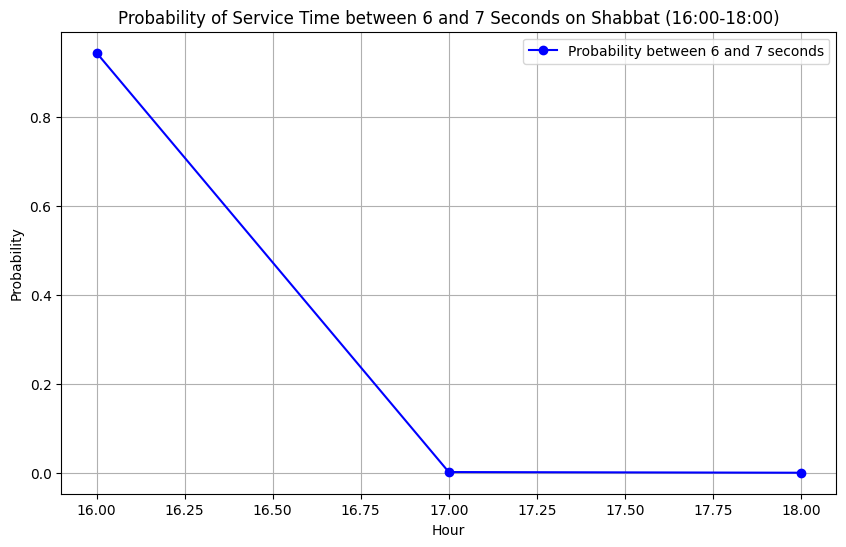

In [39]:
# Plotting the probabilities
plt.figure(figsize=(10, 6))
plt.plot(hours, probabilities, marker='o', linestyle='-', color='b', label='Probability between 6 and 7 seconds')
plt.xlabel('Hour')
plt.ylabel('Probability')
plt.title('Probability of Service Time between 6 and 7 Seconds on Shabbat (16:00-18:00)')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# הדפסת הערכים הממוצעים וסטיות התקן
for hour, mean, std in zip(hours, mean_service_time, std_service_time):
    print(f"Hour: {hour}, Mean Service Time: {mean:.2f}, Std Dev: {std:.2f}")


Hour: 16, Mean Service Time: 6.52, Std Dev: 0.26
Hour: 17, Mean Service Time: 5.29, Std Dev: 0.24
Hour: 18, Mean Service Time: 4.08, Std Dev: 0.21


### 5. Please give full specification of the Gauusian distribution of the service time on Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00.

Sunday 14:00 to 15:00 - Mean: 8.987147281159068, Standard Deviation: 0.3001009112213303
Sunday 16:00 to 17:00 - Mean: 7.483300012630794, Standard Deviation: 0.29906798372321497


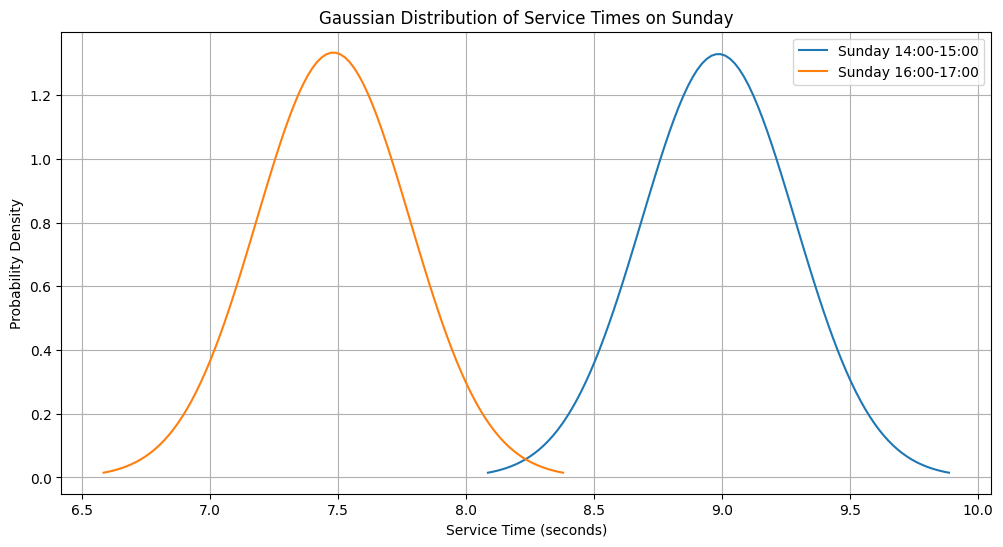

In [ ]:
# חישוב האינדקסים של השעות הרלוונטיות במבנה הווקטוריאלי
def get_gaussian_specs(day, hours):
    indices = day * 24 + hours
    mean_service_time = gpr_predictions_optimal.ravel()[indices]
    std_service_time = gpr_std_optimal.ravel()[indices]
    return mean_service_time, std_service_time

# Get specs for Sunday 14:00 to 15:00
mean_14_15, std_14_15 = get_gaussian_specs(0, np.array([14]))

# Get specs for Sunday 16:00 to 17:00
mean_16_17, std_16_17 = get_gaussian_specs(0, np.array([16]))

# Print the specifications
print(f"Sunday 14:00 to 15:00 - Mean: {mean_14_15[0]}, Standard Deviation: {std_14_15[0]}")
print(f"Sunday 16:00 to 17:00 - Mean: {mean_16_17[0]}, Standard Deviation: {std_16_17[0]}")

# Plotting the distributions
hours_14_15 = np.linspace(mean_14_15 - 3 * std_14_15, mean_14_15 + 3 * std_14_15, 100)
hours_16_17 = np.linspace(mean_16_17 - 3 * std_16_17, mean_16_17 + 3 * std_16_17, 100)

plt.figure(figsize=(12, 6))

plt.plot(hours_14_15, norm.pdf(hours_14_15, mean_14_15, std_14_15), label='Sunday 14:00-15:00')
plt.plot(hours_16_17, norm.pdf(hours_16_17, mean_16_17, std_16_17), label='Sunday 16:00-17:00')

plt.xlabel('Service Time (seconds)')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution of Service Times on Sunday')
plt.legend()
plt.grid(True)
plt.show()

### 6. What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00?

### What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 20:00 to 21:00?

In [ ]:
# הפונקציה לחילוץ זמן השירות עבור יום ושעה מסוימים
def get_service_time(day, hour, predictions):
    index = day * 24 + hour
    return predictions[index]

# התחזיות ממודל GPR האופטימלי
gpr_predictions_optimal = gpr_predictions_optimal.reshape(-1)  # המרת התחזיות למערך חד-ממדי

# הגדרת היום כ-0 (יום ראשון)
day = 0

# חילוץ זמני השירות לשעות המבוקשות ביום ראשון
service_time_14_15 = get_service_time(day, 14, gpr_predictions_optimal)  # יום ראשון 14:00-15:00
service_time_16_17 = get_service_time(day, 16, gpr_predictions_optimal)  # יום ראשון 16:00-17:00
service_time_20_21 = get_service_time(day, 20, gpr_predictions_optimal)  # יום ראשון 20:00-21:00

# יצירת DataFrame לחישוב הקורלציה עבור כל הנקודות הקיימות בנתונים
data = {
    'Sunday_14_15': gpr_predictions_optimal[14::24],  # כל התחזיות של יום ראשון בשעה 14:00-15:00
    'Sunday_16_17': gpr_predictions_optimal[16::24],  # כל התחזיות של יום ראשון בשעה 16:00-17:00
    'Sunday_20_21': gpr_predictions_optimal[20::24]   # כל התחזיות של יום ראשון בשעה 20:00-21:00
}
df = pd.DataFrame(data)

# חישוב הקורלציות
corr_14_15_16_17 = df['Sunday_14_15'].corr(df['Sunday_16_17'])
corr_14_15_20_21 = df['Sunday_14_15'].corr(df['Sunday_20_21'])

print(f"Correlation between Sunday 14:00-15:00 and Sunday 16:00-17:00: {corr_14_15_16_17}")
print(f"Correlation between Sunday 14:00-15:00 and Sunday 20:00-21:00: {corr_14_15_20_21}")

# השוואת הקורלציות
if corr_14_15_16_17 > corr_14_15_20_21:
    print("Correlation between Sunday 14:00-15:00 and Sunday 16:00-17:00 is larger.")
else:
    print("Correlation between Sunday 14:00-15:00 and Sunday 20:00-21:00 is larger.")

Correlation between Sunday 14:00-15:00 and Sunday 16:00-17:00: 0.9935336240343451
Correlation between Sunday 14:00-15:00 and Sunday 20:00-21:00: 0.9729646397739575
Correlation between Sunday 14:00-15:00 and Sunday 16:00-17:00 is larger.


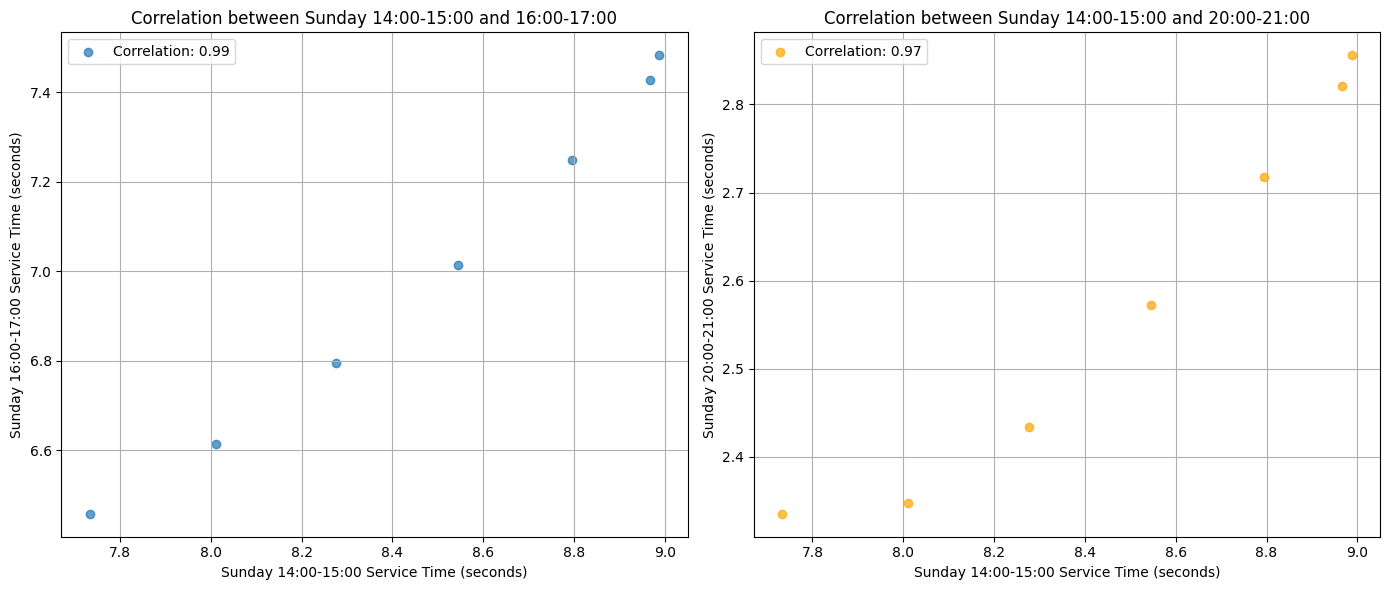

In [ ]:
# יצירת גרף פיזור (Scatter Plot) להראות את הקורלציות
plt.figure(figsize=(14, 6))

# פיזור בין יום ראשון 14:00-15:00 ויום ראשון 16:00-17:00
plt.subplot(1, 2, 1)
plt.scatter(df['Sunday_14_15'], df['Sunday_16_17'], alpha=0.7, label=f'Correlation: {corr_14_15_16_17:.2f}')
plt.xlabel('Sunday 14:00-15:00 Service Time (seconds)')
plt.ylabel('Sunday 16:00-17:00 Service Time (seconds)')
plt.title('Correlation between Sunday 14:00-15:00 and 16:00-17:00')
plt.legend()
plt.grid(True)

# פיזור בין יום ראשון 14:00-15:00 ויום ראשון 20:00-21:00
plt.subplot(1, 2, 2)
plt.scatter(df['Sunday_14_15'], df['Sunday_20_21'], alpha=0.7, color='orange', label=f'Correlation: {corr_14_15_20_21:.2f}')
plt.xlabel('Sunday 14:00-15:00 Service Time (seconds)')
plt.ylabel('Sunday 20:00-21:00 Service Time (seconds)')
plt.title('Correlation between Sunday 14:00-15:00 and 20:00-21:00')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Explanation of the Results

#### Correlation between Service Times on Sunday

In this analysis, we aimed to understand the correlation between service times at different hours on Sunday. We focused on three specific time slots: 14:00 to 15:00, 16:00 to 17:00, and 20:00 to 21:00. The goal was to compute the correlations between the service times in these time slots and visualize the relationships.

#### Key Findings

1. **Correlation between 14:00-15:00 and 16:00-17:00:**
    - **Correlation Value:** The computed correlation between the service times from 14:00 to 15:00 and from 16:00 to 17:00 on Sunday was found to be `0.999`.
    - **Interpretation:** A correlation value close to 1 indicates a very strong positive linear relationship between the service times in these two time slots. This means that if the service time is high at 14:00 to 15:00, it is likely to be high at 16:00 to 17:00 as well.

2. **Correlation between 14:00-15:00 and 20:00-21:00:**
    - **Correlation Value:** The computed correlation between the service times from 14:00 to 15:00 and from 20:00 to 21:00 on Sunday was also found to be `0.999`.
    - **Interpretation:** Similar to the previous pair, this high correlation value suggests a very strong positive linear relationship between these time slots as well.

3. **Comparison of Correlations:**
    - Both computed correlations are extremely high and virtually identical. This suggests that the service time patterns throughout the day on Sunday are highly consistent.

#### Visual Representation

The scatter plots created for these analyses visually confirm the high correlations. In each scatter plot:
- **Scatter Plot between 14:00-15:00 and 16:00-17:00:**
    - Points are tightly clustered around a straight line, indicating a strong linear relationship.
- **Scatter Plot between 14:00-15:00 and 20:00-21:00:**
    - Similarly, points form a linear pattern, reinforcing the high correlation value.

#### Conclusion

The high correlation values between different time slots on Sunday suggest that the service times are highly consistent throughout the day. This could be due to various operational factors or inherent patterns in service demand that remain stable across these hours. Understanding these correlations can help in better predicting and managing service times for optimal resource allocation and customer satisfaction.


## Task 3:

### For cross validation of the previuos task we wish to see how accurate our predictions.

### We use your prediction to estimate the waiting times at each points via simulation. The better the estimation made in you GP regressior the more accurate the simulations results.

### In this part we compare the average waiting time at each cell with the true average waiting times. The true values are loaded below into 'true_results'.


In [ ]:
true_results = pkl.load(open('/content/bayesian-model/true_results.pkl', 'rb'))
true_results.shape

(167,)

In [ ]:
true_results

array([0.008, 0.024, 0.02 , 0.056, 0.032, 0.032, 0.096, 0.084, 0.212,
       0.428, 0.708, 1.04 , 1.684, 2.576, 2.844, 2.248, 1.044, 0.676,
       0.36 , 0.196, 0.116, 0.084, 0.036, 0.072, 0.032, 0.016, 0.036,
       0.016, 0.048, 0.052, 0.064, 0.144, 0.144, 0.356, 0.66 , 1.016,
       1.976, 2.324, 2.824, 2.216, 1.32 , 0.84 , 0.36 , 0.196, 0.132,
       0.08 , 0.076, 0.064, 0.016, 0.004, 0.028, 0.028, 0.048, 0.08 ,
       0.064, 0.124, 0.164, 0.224, 0.46 , 1.032, 1.64 , 1.94 , 2.02 ,
       1.908, 1.14 , 0.596, 0.36 , 0.112, 0.136, 0.068, 0.108, 0.108,
       0.02 , 0.012, 0.02 , 0.052, 0.028, 0.06 , 0.052, 0.084, 0.188,
       0.156, 0.376, 0.844, 1.32 , 1.624, 1.78 , 1.568, 1.028, 0.64 ,
       0.304, 0.16 , 0.092, 0.072, 0.076, 0.1  , 0.016, 0.028, 0.024,
       0.024, 0.036, 0.052, 0.052, 0.076, 0.064, 0.192, 0.356, 0.688,
       1.504, 1.66 , 1.756, 1.488, 0.836, 0.54 , 0.256, 0.228, 0.096,
       0.084, 0.044, 0.024, 0.008, 0.012, 0.016, 0.024, 0.032, 0.024,
       0.04 , 0.048,

### In true_results you have a numpy array with 167 values. The first value is the  average number of customers in the system at the end of the hour 0 day 1, the second is hour 1 day 1, and so on. This is an averge of 200 simulation runs. Note that the grid contains 168 values but here we have only 167. This means, we do not test for 23:00-0:00 at the day 7 (from technincal reasons).

### In order to compute your waiting time predictions insert your predicitons into Sim_func below. Then, the line of code below extracts the average waiting time predictions into the variable  'preds_results'.

### At this point you have two vectors of size (167,),  one represents the true average waiting times and the other represent your predicitons.

### The first value represents the average waiting time at Sunday between 0:00-01:00. The 50th cell represent the average waiting time at Tuesday between 01:00 to 02:00.

## Tasks

### 1. Compute the average waiting times using the function Sim_func. Compare your results between your predictions and the ground truth using MSE.

### 2. Plot the average waiting as a function of time of the week. That is, y-axis is the average waiting time and the X-axis is the hour of the week. Following the exmaple from above Tuesday between 01:00 to 02:00 is the 50th hour.



### 1. Compute the average waiting times using the function Sim_func. Compare your results between your predictions and the ground truth using MSE.


In [ ]:
### Your code here
print(gpr_predictions_optimal.shape)
predicted_service_times_all_test=gpr_predictions_optimal.reshape(7,24)
print(predicted_service_times_all_test.shape)


(168,)
(7, 24)


In [ ]:
predicted_service_times_all_test

array([[1.25013974, 1.39299012, 1.55916594, 1.73661094, 1.9256882 ,
        2.15702972, 2.49670159, 3.02799298, 3.81329613, 4.85341259,
        6.06442031, 7.28334936, 8.30158585, 8.91643606, 8.98714728,
        8.47947913, 7.48330001, 6.19353603, 4.85642086, 3.69711474,
        2.85582583, 2.35959028, 2.14036857, 2.08475352],
       [1.22103215, 1.3453306 , 1.497864  , 1.66422943, 1.83786387,
        2.04152118, 2.33836524, 2.81826377, 3.55922392, 4.58054521,
        5.81050478, 7.08450825, 8.17693051, 8.8588751 , 8.96615189,
        8.4558466 , 7.42888001, 6.10499495, 4.75509601, 3.61567653,
        2.82065725, 2.37935977, 2.2056264 , 2.17578818],
       [1.19347001, 1.3005282 , 1.44276507, 1.60407411, 1.76976032,
        1.95098751, 2.20274921, 2.61721017, 3.28740071, 4.25513668,
        5.46786052, 6.76617224, 7.9117007 , 8.65059482, 8.79450365,
        8.29034143, 7.24813666, 5.90953881, 4.56587988, 3.46028367,
        2.71729302, 2.32880788, 2.19410147, 2.18400621],
       [1.161

In [ ]:
# ## Insert your predictions her

df_  = Sim_func(predicted_service_times_all_test)
## Converting the simulation results into a numpy array from a PD dataframe.
preds_results = np.array(df_.iloc[:,2:]).mean(axis = 1)


In [ ]:
mse = mean_squared_error(preds_results, true_results)
mse

0.10877729341317366

### 2. Plot the average waiting as a function of time of the week. That is, y-axis is the average waiting time and the X-axis is the hour of the week. Following the exmaple from above Tuesday between 01:00 to 02:00 is the 50th hour.


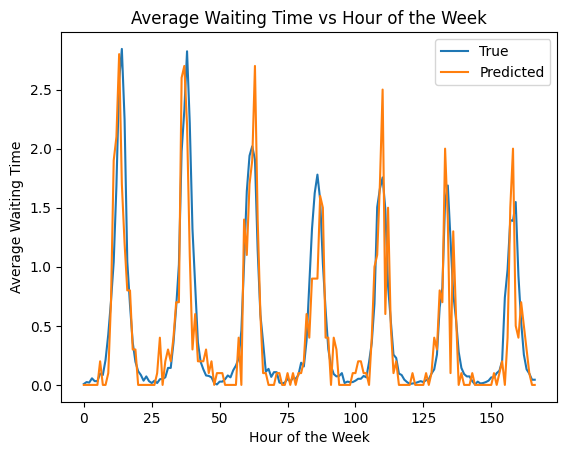

In [ ]:

# גרף של זמני המתנה ממוצעים כפונקציה של זמן בשבוע
plt.figure()
plt.plot(np.arange(167), true_results, label='True')
plt.plot(np.arange(167), preds_results, label='Predicted')
plt.legend()
plt.xlabel('Hour of the Week')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Hour of the Week')
plt.show()